In [130]:
#import libraries
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import linalg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt


import pandas as pd

import standardization as sd                                #Self written, Scikit-learn do have standardScaler which does the same.
import confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
for_feature_selection = pd.read_csv("../TrainingData/neodata/fault_all_10.csv")

# Load training data
train_data = pd.read_csv("../TrainingData/neodata/fault_all_no_noise_100.csv")
test_data = pd.read_csv("../TestData/neodata/fault_all_no_noise_100.csv")
vald_data=pd.read_csv("../ValidationData/neodata/fault_all_no_noise_100.csv")

In [132]:
#Normalization / conditioning
standardizer = sd.standardization(train_data,'target')

fts = standardizer.transform(for_feature_selection)
trn = standardizer.transform(train_data)
tst = standardizer.transform(test_data)
val = standardizer.transform(vald_data)

#trn = train_data
#tst = test_data

targets = train_data['target'].unique().tolist()        # List of classes

labels_tst = test_data['target']


SVM classifier on 10 point dataset to evaluate which features to drop

In [133]:
from sklearn import svm

clf0 = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=0.01)
clf0.fit(fts.drop('target',axis=1), fts['target'])


SVC(C=1000, decision_function_shape='ovo', gamma=0.01)

Sequential feature selector to select important features

In [134]:
from sklearn.feature_selection import SequentialFeatureSelector

features = 5

bw = SequentialFeatureSelector(clf0,direction='backward',n_jobs=8,n_features_to_select=features)

In [135]:
bw.fit(fts.drop('target',axis=1), fts['target'])

SequentialFeatureSelector(direction='backward',
                          estimator=SVC(C=1000, decision_function_shape='ovo',
                                        gamma=0.01),
                          n_features_to_select=5, n_jobs=8)

Which features are dropped?

In [136]:
labels = trn.drop('target',axis=1).columns
dropped = labels[np.invert(bw.get_support())]
dropped

Index(['Pdis', 'Psuc', 'T0', 'Tsh', 'Tsup', 'CondFan', 'CprPower', 'Density',
       'Tamb'],
      dtype='object')

How the remaining dataset looks like

In [137]:
trn = trn.drop(dropped,axis=1)
tst = tst.drop(dropped,axis=1)
val = val.drop(dropped,axis=1)

Training a full classifier on more datapoint with the features dropped

In [138]:
clf = svm.SVC( kernel="rbf", decision_function_shape="ovo", C=1000, gamma=0.01)
clf.fit(trn.drop('target',axis=1), trn['target'])

SVC(C=1000, decision_function_shape='ovo', gamma=0.01)

In [139]:
trn

,Tc,Tdis,Tret,Tsuc,Tset,target
0,-1.088636,-0.365470,-0.945271,-0.989183,-1.286825,0
1,-1.088058,-0.364793,-0.945153,-0.989137,-1.286825,0
2,-1.088752,-0.365599,-0.945298,-0.989196,-1.286825,0
3,-1.088934,-0.365799,-0.945343,-0.989219,-1.286825,0
4,-1.089220,-0.366107,-0.945416,-0.989260,-1.286825,0
...,...,...,...,...,...,...
37795,3.689506,1.778357,0.420295,0.496959,1.151370,20
37796,3.689708,1.778582,0.420274,0.496936,1.151370,20
37797,3.689643,1.778511,0.420281,0.496943,1.151370,20
37798,3.690417,1.779353,0.420215,0.496869,1.151370,20


In [140]:
#predicting
predict = clf.predict(trn.drop('target',axis=1))

print(trn['target'].to_numpy())
print(predict)

[ 0  0  0 ... 20 20 20]
[ 8  8  8 ... 20 20 20]


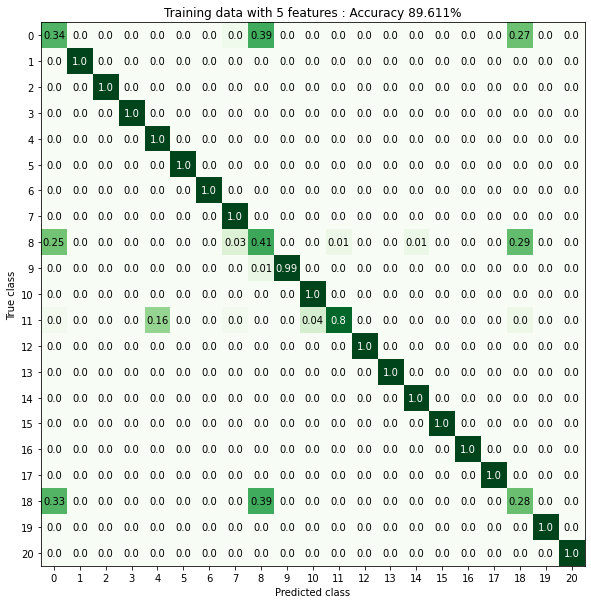

In [141]:
conf_matrix = np.zeros([21, 21])

for x,y in zip(predict,trn['target']):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = f'Training data with {features} features',eval_labels = False)
pass

In [142]:
#predicting
predict_val = clf.predict(val.drop('target',axis=1))

print(val['target'].to_numpy())
print(predict_val)

[ 0  0  0 ... 20 20 20]
[ 8  8  8 ... 20 20 20]


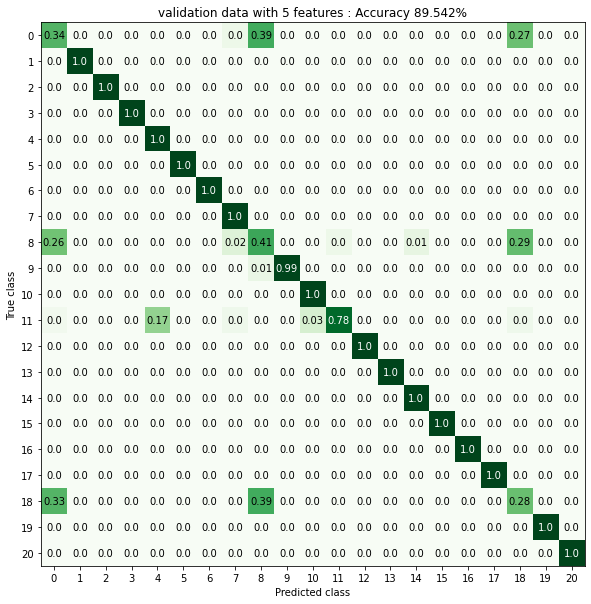

In [143]:
conf_matrix = np.zeros([21, 21])

for x,y in zip(predict_val,val['target']):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = f'validation data with {features} features',eval_labels = False)
pass

In [144]:
#predicting
predict_tst = clf.predict(tst.drop('target',axis=1))

print(val['target'].to_numpy())
print(predict_tst)

[ 0  0  0 ... 20 20 20]
[ 8  8  8 ... 20 20 20]


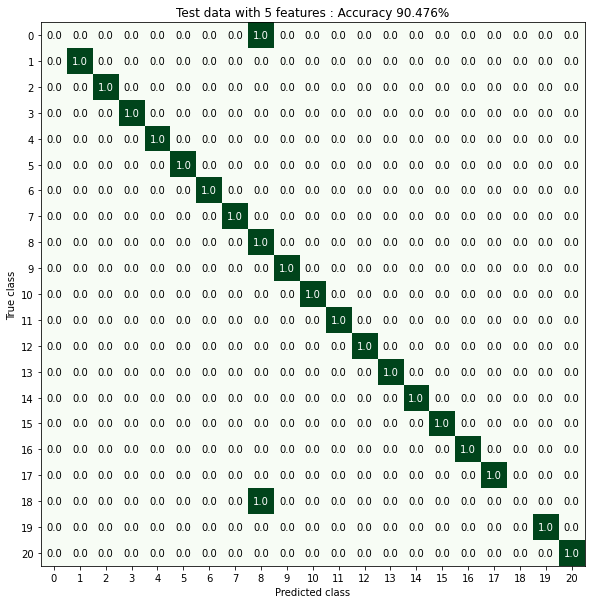

In [145]:
conf_matrix = np.zeros([21, 21])

for x,y in zip(predict_tst,tst['target']):
    conf_matrix[int(y)][int(x)] +=1

    #Generate confusion matrix pdf
confusion_matrix.confusion_matrix(conf_matrix, figsize = (10,10), title = f'Test data with {features} features',eval_labels = False)
pass